# Sparkify Project Workspace for prototyping
This workspace contains a tiny subset (128MB) of the full dataset available (12GB)

In [15]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window

from pyspark.sql.functions import count, col, to_date, udf, sum
from pyspark.sql.types import IntegerType


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')

# df.head(5)

In [5]:
df_pd = df.toPandas()
df_pd.shape

(286500, 18)

Check how many nulls exist on userID and sessionId

In [7]:
df_pd.isna().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [8]:
# Go ahaead and write script to remove nas in userId and sessionId anyway
df = df.where(col('userId').isNotNull() | col('sessionId').isNotNull())
df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Perform a groupBy on page column to get the distrbution of events performed by all users

In [9]:
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows



Assuming Cancellation Confirmation to be the churn event, there are 52 cancel events - need to check if all the 52 events are from unique userIds

In [6]:
df.filter("page = 'Cancel'").select('userId').distinct().count()

52

Looks like all the 52 users are distinct.
Calculate the percentage of churned users wrt to totalnumber of users

In [7]:
(df.filter("page = 'Cancel'") \
     .select('userId') \
     .distinct() \
     .count() * 100) / df.select('userId').distinct().count()

23.008849557522122

So 23% of the users have churned in this dataset.

As suggested, let's take a look at the Downgrade events and check how many users that canceled have downgraded

In [8]:
canceled_users = df.filter("page = 'Cancel'").select('userId').distinct().collect()
downgraded_users = df.filter("page = 'Downgrade'").select('userId').distinct().collect()

def convert_rows_to_list(rows_list):
    '''Converts a list of rows to a list. Assumes only a single column row list'''
    result = []
    for row in rows_list:
        result.append(row['userId'])
    return result
    
canceled_users = convert_rows_to_list(canceled_users)
downgraded_users = convert_rows_to_list(downgraded_users)

np.setdiff1d(np.array(downgraded_users), np.array(canceled_users)).shape

(119,)

There are 119 users who downgraded but not canceled

In [9]:
# Check how many canceled users have downgraded
counter = 0
for cu in canceled_users:
    if cu in set(downgraded_users):
        counter+=1
        
print("Percentage of canceled users in downgraded users {}".format(counter * 100 / len(canceled_users)))

Percentage of canceled users in downgraded users 67.3076923076923


I think we can use downgrade as one of the features, if possible, but losing the user is more important than a downgrading user and I plan to focus on 'canceling' users for this analysis

#### Add a churn column to the dataframe for the churned (canceled) users

In [10]:
add_churn = udf(lambda x : 1 if x is not None else 0, IntegerType())

df_canceled_users = df.filter("page = 'Cancel'")\
                      .select('userId')\
                      .distinct()\
                      .withColumn('churn', add_churn(col('userId')))


# Join df_canceled_users with df
df = df.join(df_canceled_users, on = ['userId'], how = 'left')

# Fill null in churn column with 0s
df = df.fillna({'churn': 0})

In [11]:
# Churned user count
df.select('churn', 'userId').distinct().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  174|
+-----+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Paid/free users

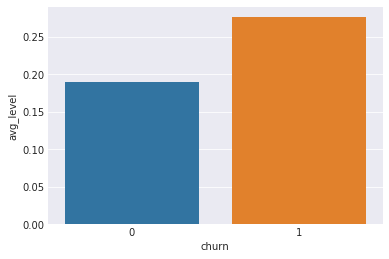

In [16]:
# 1. How many paid and unpaid users churn? Intuition is unpaid users cancel their subscription 
# more than paid users for a good reason
add_level = udf(lambda x: 1 if x == "free" else 0, IntegerType())
df = df.withColumn("level_num", add_level(df.level))

avg_level_df = df.groupBy('churn').agg({'level_num':'avg'}) \
                 .withColumnRenamed('avg(level_num)', 'avg_level') \
                 .toPandas()

plt.figure()
sns.barplot(x = 'churn', y = 'avg_level', data = avg_level_df)

Average level is a bit higher in churned users, this goes on to show that paid users have a higher affinity to leave

#### Ad_served

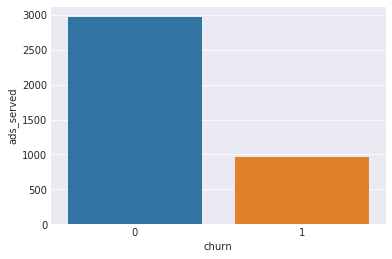

In [17]:
# Lets see how ads served is related to churn

# Add a column that adds a 1 to every ad shown or page = Roll advert
add_ad_served = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
df = df.withColumn("ad_served", add_ad_served(df.page))

df_ads_pd = df.groupBy('churn').agg({'ad_served':'sum'})\
                .select('churn',col('sum(ad_served)').alias('ads_served'))\
                .toPandas()

plt.figure()
sns.barplot(x = 'churn', y = 'ads_served', data = df_ads_pd)


Therefore on an avg a churned user is shown lesser number of ads on an average.
So we can use total number of ads as one of the features

#### Number of songs played

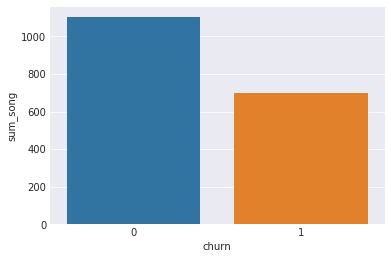

In [20]:
# Number of songs a user listens to should have an effect on churn
# Add next_song
add_next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
df = df.withColumn("song", add_next_song(df.page))

next_song_df = df.groupBy('userId','churn')\
                .agg({'artist':'count'})\
                .groupBy('churn')\
                .agg({'count(artist)' : 'avg'})\
                .withColumnRenamed('avg(count(artist))', 'sum_song')\
                .toPandas()
    
plt.figure()
sns.barplot(x = 'churn', y = 'sum_song', data = next_song_df)

This goes on to show that a churned user on average listens to much less number of songs. So number of songs is a 
good feature to include

#### Songs added to playlist

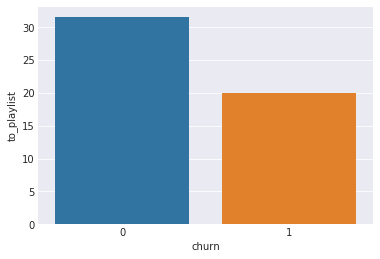

In [22]:
## Adding a song to playlist 
# Add to_playlist
add_to_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
df = df.withColumn("to_playlist", add_to_playlist(df.page))

to_playlist_df = df.groupBy('userId','churn')\
                    .agg({'to_playlist':'sum'})\
                    .groupBy('churn')\
                    .agg({'sum(to_playlist)' : 'avg'})\
                    .withColumnRenamed('avg(sum(to_playlist))', 'to_playlist')\
                    .toPandas()
    
plt.figure()
sns.barplot(x = 'churn', y = 'to_playlist', data = to_playlist_df)

Churned users add lesser number of songs to the playlist and this makes intuitive sense

#### Adding friends

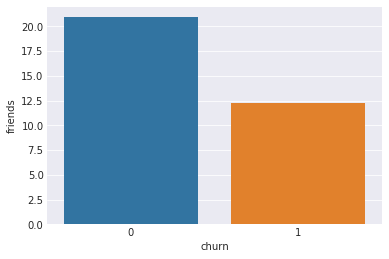

In [23]:
## Adding friends
# Add to add_friend
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
df = df.withColumn("friend", add_friend(df.page))

add_friend_df = df.groupBy('userId','churn')\
                    .agg({'friend':'sum'})\
                    .groupBy('churn')\
                    .agg({'sum(friend)' : 'avg'})\
                    .withColumnRenamed('avg(sum(friend))', 'friends')\
                    .toPandas()
plt.figure()
sns.barplot(x = 'churn', y = 'friends', data = add_friend_df)

Churned users are less socially active on the app

#### Accessing help and settings

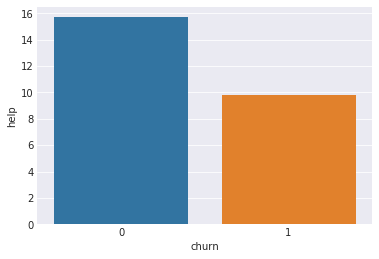

In [24]:
## Accessing help and settings is for more involved users. Lets see if they churn more

# Add help_settings
add_help = udf(lambda x: 1 if x in ["Help", "Settings"] else 0, IntegerType())
df = df.withColumn("help", add_help(df.page))

help_df = df.groupBy('userId','churn')\
            .agg({'help':'sum'})\
            .groupBy('churn')\
            .agg({'sum(help)' : 'avg'})\
            .withColumnRenamed('avg(sum(help))', 'help')\
            .toPandas()

plt.figure()
sns.barplot(x = 'churn', y = 'help', data = help_df)

Churned users seek less help

#### Gender

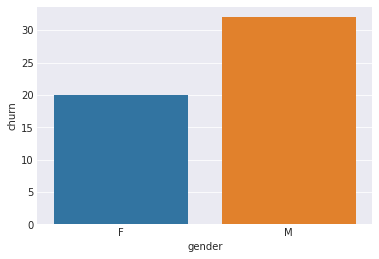

In [25]:
## Check if gender affects the churn number
df_gender = df.select('userId','gender','churn')\
                .distinct()\
                .groupBy('gender')\
                .sum()\
                .withColumnRenamed('sum(churn)', 'churn')\
                .toPandas()

plt.figure()
sns.barplot(x = 'gender', y = 'churn', data = df_gender)

More males churned than females - this could a feature that we could use

#### Thumbs ratio

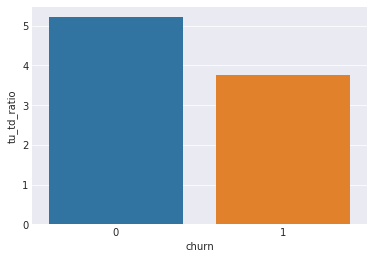

In [27]:
## Lets calculate a thumbsup to thumbsdown ratio. Higher this ratio, the more songs a typical user likes. 
# expecting this number to be higher for un-churned users

# Add thums_up
add_tu = udf(lambda x:1 if x == "Thumbs Up" else 0, IntegerType())
df = df.withColumn("tu", add_tu(df.page))

# Add thumbs down
add_td = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
df = df.withColumn("td", add_td(df.page))

df = df.withColumn("thumbs_ratio", df.tu / df.td)

thumbs_df = df.groupBy('userId','churn')\
                .agg({'tu':'sum', 'td':'sum'})\
                .groupBy('churn')\
                .agg({'sum(td)':'sum', 'sum(tu)':'sum'})\
                .withColumn('tu_td_ratio', col('sum(sum(tu))') / col('sum(sum(td))'))\
                .toPandas()

plt.figure()
sns.barplot(x = "churn", y = "tu_td_ratio", data = thumbs_df)


Unchurned users tend to like the quality of songs compared to unchurned users

In [30]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: integer (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- level_num: integer (nullable = true)
 |-- ad_served: integer (nullable = true)
 |-- to_playlist: integer (nullable = true)
 |-- friend: integer (nullable = true)
 |-- help: integer (nullable = true)
 |-- tu: integer (nullable = true)
 |-- td: integer (nullable 

In [31]:
# Aggregate the data into a master_df with features aggregated

master_df = df.groupBy(['userId','churn','gender'])\
    .agg({'ad_served':'sum',
         'length':'sum',
         'artist':'count',
         'to_playlist':'sum',
         'friend':'sum',
         'help':'sum',
         'tu':'sum',
         'td':'sum',
          'level':'avg'
         }).withColumnRenamed('sum(length)', 'sum_length')\
           .withColumnRenamed('count(artist)', 'sum_song')\
    .withColumnRenamed('sum(to_playlist)', 'sum_playlist')\
    .withColumnRenamed('sum(friend)','sum_friend')\
    .withColumnRenamed('sum(help)','sum_help')\
    .withColumnRenamed('sum(tu)', 'sum_tu')\
    .withColumnRenamed('sum(td)', 'sum_td')\
    .withColumnRenamed('sum(ad_served)', 'sum_ad_served')\
    .withColumnRenamed('avg(level)','avg_level')

In [32]:
master_df.toPandas().isna().sum()

userId             0
churn              0
gender             1
sum_tu             0
sum_friend         0
sum_td             0
sum_help           0
sum_song           0
sum_ad_served      0
sum_length         1
sum_playlist       0
avg_level        226
dtype: int64

In [33]:
# From above, avg_level has a bunch of NAs that need to be filled. We can consider, avg_level to be zero or a free user,
# when level is NA
master_df = master_df.fillna({'avg_level':0.0})

In [34]:
# Need to convert gender to numeric (1 = M and 0 = F)
# Need to create a tu/td ratio. Call this thumbs_ratio

convert_gender = udf(lambda x: 1 if x == "M" else 0, IntegerType())

master_df = master_df.withColumn('gender_num', convert_gender(master_df.gender))\
                    .withColumn('thumbs_ratio', master_df.sum_tu / master_df.sum_td)

master_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: string (nullable = true)
 |-- sum_tu: long (nullable = true)
 |-- sum_friend: long (nullable = true)
 |-- sum_td: long (nullable = true)
 |-- sum_help: long (nullable = true)
 |-- sum_song: long (nullable = false)
 |-- sum_ad_served: long (nullable = true)
 |-- sum_length: double (nullable = true)
 |-- sum_playlist: long (nullable = true)
 |-- avg_level: double (nullable = false)
 |-- gender_num: integer (nullable = true)
 |-- thumbs_ratio: double (nullable = true)



In [35]:
## Switch churn to label - this allows classifier to pick the right column up for the classification task
master_df = master_df.withColumnRenamed('churn', 'label')

In [36]:
# Create features
# Build assembled features
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler

assembler = VectorAssembler(inputCols = ["sum_song", "sum_friend", "sum_help", "sum_ad_served", "sum_length", "sum_playlist",
                                        "thumbs_ratio","gender_num", "avg_level"],
                            outputCol = "features", handleInvalid="skip")

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier

In [39]:
# Split the dataset
rest, validate = master_df.randomSplit([0.8, 0.2], seed = 42)

In [40]:
# Using Gradient Boosted Tree Classifier
gdbt = GBTClassifier(featuresCol="scaledFeatures")
pipeline = Pipeline(stages = [assembler, scaler, gdbt])
model = pipeline.fit(rest)

In [41]:
result = model.transform(validate)

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Using F-score for validation as the dataset is heavily imbalanced

In [43]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(result, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7192982456140351


In [44]:
## RandomForestClassifier

rf = RandomForestClassifier(featuresCol="scaledFeatures")

pipeline = Pipeline(stages = [assembler, scaler, rf])
model = pipeline.fit(rest)

result = model.transform(validate)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(result, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.6569200779727097


In [45]:
## LogisticRegression

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages = [assembler, scaler, lr])
model = pipeline.fit(rest)

result = model.transform(validate)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(result, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.6057347670250895


Gradient Boosting seems to be generate best results for this feature subset

# Next Steps
Crossvalidation and hyperparameter tuning using grid-based search is computationally not possible in this workspace. Code below is executed on AWS EMR cluster using the script file Sparkify.py

In [21]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# paramGrid = ParamGridBuilder() \
#     .addGrid(gdbt.maxDepth, [5, 10]) \
#     .addGrid(gdbt.maxBins, [32, 64]) \
#     .build() 


# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=MulticlassClassificationEvaluator(),
#                           numFolds=3)

# model = crossval.fit(rest)

# result = model.transform(validate)

# evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
# f1_score = evaluator.evaluate(result, {evaluator.metricName: "f1"})
# print("f1: {}".format(f1_score))